## Modelo para resolución del problema

Se va a aplicar un modelo supervisado de clasificación.

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Para el transformer BoolToNum
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

La utilización del formato parquet permite leer los datos del fichero y a la vez los formatos de los campos sin necesidad de inferirlos, ya que quedan grabados en el propio fichero.

In [2]:
alquiler = pd.read_parquet("../data/madrid-rent-prices_4-abr_cleaned.parquet")
alquiler.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1479 entries, 6 to 7016
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   zipCode                1479 non-null   object         
 1   buildingSubtype        1479 non-null   category       
 2   clientTypeId           1479 non-null   category       
 3   dateOriginal           1479 non-null   datetime64[ns] 
 4   bathrooms              1479 non-null   int8           
 5   balcony                1479 non-null   int8           
 6   air_conditioner        1479 non-null   int8           
 7   heater                 1479 non-null   int8           
 8   heating                1479 non-null   int8           
 9   swimming_pool          1479 non-null   int8           
 10  parking                1479 non-null   int8           
 11  conservationState      1479 non-null   category       
 12  floor                  1479 non-null   int8     

De los datos leidos, se va a eliminar las siguientes variables:

* `publishedDays` puesto que es información que no influye en el cálculo del precio de la renta
* `zipCode` es información redundante con la latitud y la longitud
* `dateOriginal` ya que no vamos a realizar un estudio de la serie temporal
* `price_var` porque para el tipo de estudio que queremos hace no tiene importancia la evolución del precio, y las bajadas y/o subidas en los precios ya están recogidas en la variable `price` que utilizaremos como _target_

In [3]:
alquiler.drop(['publishedDays', 'zipCode', 'dateOriginal', 'price_var'], axis=1, inplace=True)

### Revisión periodidicidad de pago

Una de las columnas es la periodicidad. Esta columna tiene la siguiente table de frecuencias

In [5]:
alquiler.periodicityId.value_counts()

Mensual        1478
Desconocido       1
Name: periodicityId, dtype: int64

Solo existe una fila con periodiciad _Desconocido_, vamos a ver sus datos y si encaja con una periodicidad de pago mensual, todas las filas tendrían en mismo valor, por tanto podríamos eliminar la variable

In [6]:
alquiler.loc[alquiler.periodicityId=="Desconocido",('surface','price')]

,surface,price
index,,
5359,55.0,745.8


Como se aprecia, cuadra perfectamente con un pago mensual de una renta, por lo que vamos a eliminar la columna.

In [7]:
alquiler.drop('periodicityId', axis=1, inplace=True)

### Separación en train y test

Antes de realizar la separación entre train y test, se realiza el entrenamiento del transformador de datos para que sepa convertir los valores independientemente de que aparezcan posteriormente en cualquiera de los subconjuntos.

In [8]:
# Es una clase que se puede utilizar dentro de un pipeline para transformar 
# todas las col bool en numéricas.
class BoolToNum (BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y = None):
        _X = X.copy()
        for bcol in _X.select_dtypes("bool").columns.to_list():
            _X[bcol] = _X[bcol].replace({True: 1, False: 0})
        return _X

In [9]:
def transform_data (X):
    cat_cols = X.select_dtypes(["category", "object"]).columns.to_list()
    num_cols = X.select_dtypes(["number", "bool"]).columns.to_list()
    transformer = make_column_transformer(
        (OneHotEncoder(), cat_cols),
        (StandardScaler(), num_cols),
        remainder='passthrough')


    pipe1 = Pipeline([
        ("boolToNum", BoolToNum()),
        ("transformer", transformer),
    ])

    return pipe1.fit(X)


# Este transformador servirá para adaptar los datos para el entrenamiento y la predicción
transform = transform_data(alquiler.loc[:, alquiler.columns != "price"])

In [10]:
Xtrain, Xtest, ytrain, ytest = train_test_split(alquiler.loc[:,alquiler.columns!="price"], 
                                                alquiler.price, 
                                                test_size=0.1)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((1331, 22), (148, 22), (1331,), (148,))

### Construcción del modelo

La función `best_model` nos ayudará a realizar el entrenamiento y validación con diferentes parámetros para el `fine tunning` y pudiendo variar el estimador


In [68]:
def best_model(estimator, params, 
               Xtrain=Xtrain, ytrain=ytrain, 
               scoring="neg_mean_squared_error", return_train_score=True):

    clf = GridSearchCV(estimator=estimator, 
                    param_grid=params, 
                    cv=5,
                    return_train_score=return_train_score,
                    scoring=scoring)

    clf.fit(Xtrain, ytrain)

    print("Best parameters:")
    print(f"Métrica {clf.scoring}: {clf.best_score_:.2f}")
    print(f"Parámetros: {clf.best_params_}")
    return clf


def plot_train_validation_error(train_error, validation_error,
                                best_params,
                                xlabel,
                                xlabels,
                                rotation=0):
    plt.plot(xlabels, train_error, label="train")
    plt.plot(xlabels, validation_error, label="validation")
    x_min_error = np.argmin(validation_error)
    min_error = validation_error[x_min_error]
    plt.annotate(best_params,
                (xlabels[x_min_error], min_error-(min_error*.05)))
    plt.axhline(y=min_error, color="red", linestyle="--")
    plt.axvline(x=xlabels[x_min_error], color="red", linestyle="--")
    plt.legend()
    plt.ylabel("RMSE")
    plt.xlabel(xlabel)
    plt.title("Train vs Validation")
    plt.xticks(rotation=rotation)
    plt.grid()
    plt.show()

Realizamos una primera prueba con el estimador `RandomForestRegressor()` y variando algunos parámetros como el número de estimadores y la máxima profundidad del árbol. 

In [58]:
params = {
    'n_estimators': list(range(9,13)),
    'max_depth': list(range(4,15))
}
clf1 = best_model(RandomForestRegressor(random_state=24), params,
                 Xtrain=transform.transform(Xtrain),
                 ytrain=ytrain)



Best parameters:
Métrica neg_mean_squared_error: -489830.25
Parámetros: {'max_depth': 12, 'n_estimators': 12}


In [59]:
rmse_rf_train1 = mean_squared_error(ytrain, clf1.predict(transform.transform(Xtrain)))
rmse_rf_test1 = mean_squared_error(ytest, clf1.predict(transform.transform(Xtest)))
r_2_rf_test1 = r2_score(ytest, clf1.predict(transform.transform(Xtest)))
print("RMSE train:", round(rmse_rf_train1,2))
print("RMSE test :", round(rmse_rf_test1,2))
print("R²        :", round(r_2_rf_test1,2))

RMSE train: 99915.52
RMSE test : 173103.78
R²        : 0.82


Como vemos obtenermos un R² de 0.82, se va a realizar la gráfica de los errores de validación y entrenamiento tener una idea visual de las variaciones en los errores en función de los parámetros que se aplican en el GridSearch. 

Aunque el entrenamiento utilizando el método GridSearchCV ya facilita la aplicación de los mejores parámetros encontrados, vemos que el modelo con menor RMSE se ha generado con los parámetros:
* n_estimators=12
* max_depth = 12

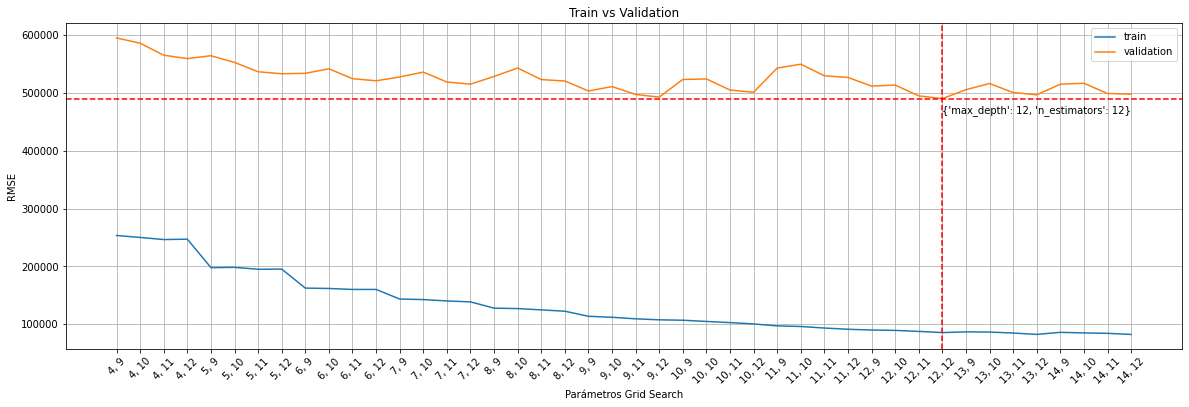

In [64]:
plt.figure(figsize=(20,6))

labels = []
for d in clf1.cv_results_["params"]:
    p = [str(v) for k,v in d.items()]
    labels.append(", ".join(p))

plot_train_validation_error(-clf1.cv_results_["mean_train_score"],
                            -clf1.cv_results_["mean_test_score"],
                            clf1.best_params_,
                            xlabel="Parámetros Grid Search",
                            xlabels= labels,
                            rotation=45
                           )

Una vez se ha centrado la construcción del modelo entorno a los parámetros indicamos vamos a ir ajustando los parámetros para intentar conseguir la mejora del modelo. En este caso se añaden otros parámetros que no tienen tanta influencia en el entrenamiento, pero que pudieran suponer una mejora

In [15]:
params = {
    'bootstrap': [True],
    'max_depth': list(range(7,15)) + [20],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': list(range(9,20))
}
clf2 = best_model(RandomForestRegressor(random_state=24), params,
                 Xtrain=transform.transform(Xtrain),
                 ytrain=ytrain)



Best parameters:
Métrica neg_mean_squared_error: -412233.98
Parámetros: {'bootstrap': True, 'max_depth': 13, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 12}


In [16]:
rmse_rf_train2 = mean_squared_error(ytrain, clf2.predict(transform.transform(Xtrain)))
rmse_rf_test2 = mean_squared_error(ytest, clf2.predict(transform.transform(Xtest)))
r_2_rf_test2 = r2_score(ytest, clf2.predict(transform.transform(Xtest)))
print("RMSE train:", round(rmse_rf_train2,2))
print("RMSE test :", round(rmse_rf_test2,2))
print("R²        :", round(r_2_rf_test2,2))

RMSE train: 233153.34
RMSE test : 173667.0
R²        : 0.82


El R² de 0.82 conseguido es igual al del modelo anterior, no hay mejora.

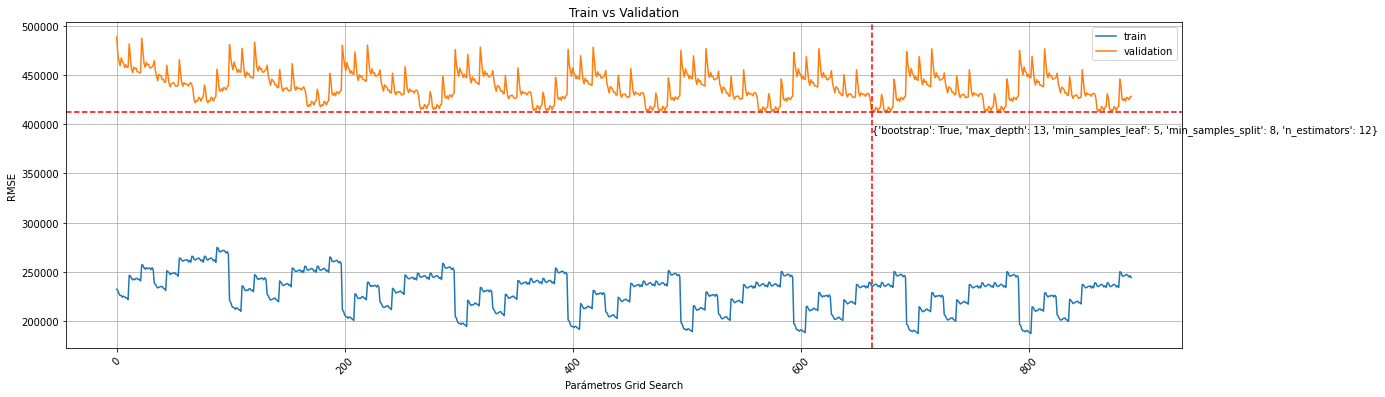

In [66]:
plt.figure(figsize=(20,6))

labels = []
for d in clf2.cv_results_["params"]:
    p = [str(v) for k,v in d.items()]
    labels.append(", ".join(p))

plot_train_validation_error(-clf2.cv_results_["mean_train_score"],
                            -clf2.cv_results_["mean_test_score"],
                            clf2.best_params_,
                            xlabel="Parámetros Grid Search",
                            xlabels= range(len(clf2.cv_results_["mean_train_score"])),
                            rotation=45
                           )

Se realizará otra prueba con variación de parámetros:

In [18]:
params = {
    'bootstrap': [True],
    'max_depth': list(range(9,15)),
    'min_samples_leaf': [5, 6, 7],
    'min_samples_split': [4, 5, 6, 7],
    'n_estimators': list(range(15,25))
}
clf3 = best_model(RandomForestRegressor(random_state=24), params,
                 Xtrain=transform.transform(Xtrain),
                 ytrain=ytrain)



Best parameters:
Métrica neg_mean_squared_error: -412992.42
Parámetros: {'bootstrap': True, 'max_depth': 13, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 17}


In [19]:
rmse_rf_train3 = mean_squared_error(ytrain, clf3.predict(transform.transform(Xtrain)))
rmse_rf_test3 = mean_squared_error(ytest, clf3.predict(transform.transform(Xtest)))
r_2_rf_test3 = r2_score(ytest, clf3.predict(transform.transform(Xtest)))
print("RMSE train:", round(rmse_rf_train3,2))
print("RMSE test :", round(rmse_rf_test3,2))
print("R²        :", round(r_2_rf_test3,2))

RMSE train: 228311.12
RMSE test : 160593.58
R²        : 0.83


### Conclusiones del modelo

En esta última prueba hemos conseguido una mejora en el rendimiento del modelo del 1%, no es muy alta, pero se escogería como modelo final para el sistema. Así pues, el modelo estaría implementado de la siguiente forma:
- Las features del modelo serían: 
  - buildingSubtype
  - clientTypeId
  - bathrooms
  - balcony
  - air_conditioner
  - heater
  - heating
  - swimming_pool
  - parking
  - conservationState
  - floor
  - terrace
  - elevator
  - rooms
  - surface
  - isHighlighted
  - isPackPremiumPriority
  - isNewConstruction
  - isOpportunity
  - otherFeaturesCount
  - lon
  - lat
- Estas features hay que transformarlas mediante `transform.transform(X)`, que realiza las siguientes operaciones:
  - Transformación de las variables booleanas a numéricas {1,0}
  - OneHotEncoding de todas las variables categóricas
  - Estandarización de todas las variables numéricas
- Para realizar la predicción del modelo se utilizaría `clf3.predict()`
- Con este modelo se ha conseguido un $R^2=0.83$ sobre el conjunto de test
